In [1]:
import os
import sys
import glob
from time import strftime, localtime
import pickle

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from scipy.fft import fft
from scipy.io import loadmat

if '..' not in sys.path:
    sys.path.append('..')
from deep_utils import *

%matplotlib inline

First, let's fix the seed of the RNG, for reproducibility purposes

In [2]:
use_good_seed = False

with open('/dev/random', 'rb') as fid:
    seed = int.from_bytes(fid.read(4), 'little')

if use_good_seed:
    seed = 1057901520

tf.random.set_seed(seed)

print('Seed: {}'.format(seed))

Seed: 1766670137


#### Load the data

In [3]:
data_folder = '../pan/npz_files/'
inertia = {key: np.arange(2,11) + i/3 for i,key in enumerate(('training', 'test', 'validation'))}
time, x, y = load_data(data_folder, inertia)
x['train'] = x.pop('training')
y['train'] = y.pop('training')
N = x['train'].shape[1]

#### Normalize the data

In [4]:
x_train_mean = np.mean(x['train'])
x_train_std = np.std(x['train'])
for key in x:
    x[key] = (x[key] - x_train_mean) / x_train_std

Let's take a look at the data:

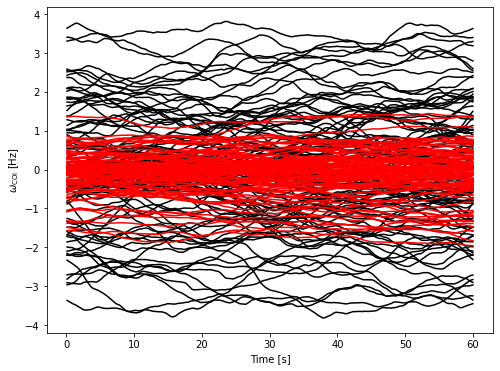

In [5]:
fig,ax = plt.subplots(1, 1, figsize=(8,6))
ax.plot(time, tf.transpose(x['train'][:100,:]), 'k')
ax.plot(time, tf.transpose(x['train'][-100:,:]), 'r')
ax.set_xlabel('Time [s]')
ax.set_ylabel(r'$\omega_{\mathrm{COI}}$ [Hz]');

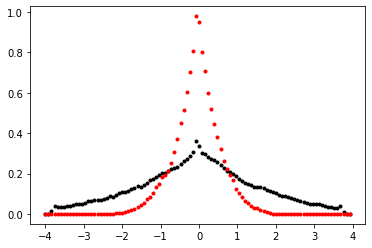

In [6]:
idx,_ = np.where(y['train'] == 2)
n,edges = np.histogram(np.ndarray.flatten(x['train'].numpy()[idx,:]), bins=100, range=[-4,4], \
                       density=True)
plt.plot(edges[:-1], n, 'k.')
idx,_ = np.where(y['train'] == 10)
n,edges = np.histogram(np.ndarray.flatten(x['train'].numpy()[idx,:]), bins=100, range=[-4,4], \
                       density=True)
plt.plot(edges[:-1], n, 'r.')
# plt.ylim([0,1])

### Build the network
The network topology used here is taken from the following paper:

George, D., & Huerta, E. A. (2018). Deep neural networks to enable real-time multimessenger astrophysics. Physical Review D, 97(4), 044039. http://doi.org/10.1103/PhysRevD.97.044039

In [7]:
with_dropout = False
dropout_coeff = 0.2
depth_level = 1
learning_rate = 1e-4

N_units = {}

if depth_level == 1:
    N_units['conv'] = [16, 32, 64]
elif depth_level == 2:
    N_units['conv'] = [64, 128, 256, 512]

N_units['pooling'] = [4 for _ in range(len(N_units['conv']))]
kernel_size = [5 for _ in range(len(N_units['conv']))]

model = tf.keras.models.Sequential([
    tf.keras.layers.Reshape((N,1), input_shape=(N,)),
])

for N_conv,N_pooling,sz in zip(N_units['conv'], N_units['pooling'], kernel_size):
    model.add(tf.keras.layers.Conv1D(N_conv, sz, activation=None))
    model.add(tf.keras.layers.MaxPooling1D(N_pooling))
    model.add(tf.keras.layers.ReLU())
    
model.add(tf.keras.layers.Flatten())
if depth_level == 2:
    model.add(tf.keras.layers.Dense(128, activation='relu'))
    
model.add(tf.keras.layers.Dense(64, activation='relu'))

if with_dropout:
    model.add(tf.keras.layers.Dropout(dropout_coeff))

model.add(tf.keras.layers.Dense(y['train'].shape[1]))

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
loss = tf.keras.losses.MeanAbsoluteError()

model.compile(optimizer=optimizer, loss=loss)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 600, 1)            0         
_________________________________________________________________
conv1d (Conv1D)              (None, 596, 16)           96        
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 149, 16)           0         
_________________________________________________________________
re_lu (ReLU)                 (None, 149, 16)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 145, 32)           2592      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 36, 32)            0         
_________________________________________________________________
re_lu_1 (ReLU)               (None, 36, 32)            0

#### Train the network

In [ ]:
ts = strftime('%Y%m%d-%H%M%S', localtime())
path = 'inertia/' + ts
checkpoint_path = path + '/checkpoints'

os.makedirs(checkpoint_path)
# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path + \
                                                 '/weights.{epoch:02d}-{val_loss:.2f}.h5',
                                                 save_weights_only=False,
                                                 save_best_only=True,
                                                 monitor='val_loss',
                                                 verbose=0)

EPOCHS = 150
BATCH_SIZE = 128
N_batches = np.ceil(x['train'].shape[0] / BATCH_SIZE)
STEPS_PER_EPOCH = np.max([N_batches, 100])
history = model.fit(x['train'], y['train'], epochs=EPOCHS, batch_size=BATCH_SIZE,
                    steps_per_epoch=STEPS_PER_EPOCH, validation_data=(x['val'], y['val']),
                    verbose=1, callbacks=[cp_callback])

#### Plot the loss as a function of the epoch number

In [ ]:
epochs = np.r_[0 : len(history.history['loss'])] + 1
plt.plot(epochs, history.history['loss'], 'k', label='Training')
plt.plot(epochs, history.history['val_loss'], 'r', label='Validation')
plt.legend(loc='best')
plt.xlabel('Epoch')
plt.ylabel('Loss');

#### Find the best model based on the validation loss

In [ ]:
checkpoint_path = '/home/daniele/Research/deep-power/trained_networks/20201206-221201/checkpoints'
checkpoint_files = glob.glob(checkpoint_path + '/*.h5')
val_loss = [float(file[:-3].split('-')[-1]) for file in checkpoint_files]
best_checkpoint = checkpoint_files[np.argmin(val_loss)]
best_model = tf.keras.models.load_model(best_checkpoint)

#### Compute the network prediction on the test set

In [ ]:
y_cnn = best_model.predict(x['test'])

#### Compute the Mean Absolute Percentage Error on the CNN prediction

In [ ]:
mape_cnn = tf.keras.losses.mean_absolute_percentage_error(tf.transpose(y['test']), \
                                                          tf.transpose(y_cnn)).numpy()[0]
print('MAPE on CNN prediction ... {:.2f}%'.format(mape_cnn))

#### Plot the results obtained with the CNN

In [ ]:
fig,ax = plt.subplots(1, 1, figsize=(8,5))
limits = np.squeeze(y['train'].numpy()[[0,-1]])
limits[1] += 1
ax.plot(limits, limits, 'g--')
ax.plot(y['test'], y_cnn, 'o', color=[1,.7,1], markersize=4, \
        markerfacecolor='w', markeredgewidth=1)
for i in range(int(limits[0]), int(limits[1])):
    idx,_ = np.where(np.abs(y['test'] - (i + 1/3)) < 1e-3)
    m = np.mean(y_cnn[idx])
    s = np.std(y_cnn[idx])
    ax.plot(i+1/3 + np.zeros(2), m + s * np.array([-1,1]), 'm-', linewidth=2)
    ax.plot(i+1/3, m, 'ms', markersize=8, markerfacecolor='w', \
            markeredgewidth=2)
ax.set_title('CNN')
ax.set_xlabel('Expected value')
ax.set_ylabel('Predicted value')
ax.axis([1.8, limits[1], 0, limits[1]]);

In [ ]:
parameters = {'N_samples': N, 'seed': seed, 'with_dropout': with_dropout,
              'depth_level': depth_level, 'N_units': N_units, 'kernel_size': kernel_size,
              'N_epochs': EPOCHS, 'batch_size': BATCH_SIZE, 'steps_per_epoch': STEPS_PER_EPOCH,
              'mape_cnn': mape_cnn, 'learning_rate': learning_rate, 'y_test': y['test'],
              'y_cnn': y_cnn}

In [ ]:
best_model.save(path)
pickle.dump(parameters, open(path + '/parameters.pkl', 'wb'))
pickle.dump(history.history, open(path + '/history.pkl', 'wb'))